In [35]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import pySuStaIn
import numpy as np
import matplotlib.gridspec as gridspec
from IPython.display import Image
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_rows', 20)

Paper: https://www.nature.com/articles/s41467-018-05892-0 <br>
Library: https://github.com/ucl-pond/pySuStaIn

# Preprocessing
### Get data

In [2]:
imaging_data = pd.read_csv('/jet/home/mare398/ADNI_Freesurfer_EDA/harmonized_imaging_data_copy.csv')
# df.head(2)

In [3]:
patient_data = pd.read_csv('/jet/home/mare398/ADNI_Freesurfer_EDA/patient_data.csv')
patient_data['Sex'] = patient_data['Sex'].replace({'F':0,'M':1})
patient_data.head(2)

,Unnamed: 0,Image_Data_ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,...,location,RID,ID,SITEID,VISCODE,VISCODE2,USERDATE,PTGENDER,PTDOBMM,PTDOBYY
0,0,I105437,941_S_1202,CN,1,79,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,...,ADNI_941_S_1202_MR_MPR__GradWarp__B1_Correctio...,1202,2398,127,sc,sc,1/11/07,1,7,1929
1,1,I204843,941_S_1202,CN,1,81,8,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,...,ADNI_941_S_1202_MR_MPR__GradWarp__B1_Correctio...,1202,2398,127,sc,sc,1/11/07,1,7,1929


In [4]:
df = imaging_data.merge(patient_data, left_on=["Image_Data_ID", "Subject", "Acq_Date"], right_on=["Image_Data_ID", "Subject", "Acq_Date"])
df.head(1)

,Unnamed: 0_x,Subject,Image_Data_ID,Acq_Date,Scanner_Proxy,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,...,location,RID,ID,SITEID,VISCODE,VISCODE2,USERDATE,PTGENDER,PTDOBMM,PTDOBYY
0,1,941_S_1202,I105437,2/28/08,1.5T 127,2.293995,2.374323,2.365546,1.751561,2.373949,...,ADNI_941_S_1202_MR_MPR__GradWarp__B1_Correctio...,1202,2398,127,sc,sc,1/11/07,1,7,1929


In [5]:
df.shape

(3309, 154)

In [6]:
control=df[df['Group'] == 'CN']
control.shape

(997, 154)

In [7]:
imaging_features = list(control.columns)[5:-25]


### Regress out covariates

In [8]:
covariates = ['Age', 'Sex']

In [9]:
X = control[covariates]
y=control[imaging_features[0]]
reg = LinearRegression().fit(X,y)
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
#Fit linear regression models
coeffs = {}
for i in imaging_features:
    y=control[i]
    reg = LinearRegression().fit(X,y)
    coeffs[i] = reg.coef_

In [11]:
#Regress out covariates
df_img_regressed = df.copy()
for i in imaging_features:
    df_img_regressed[i] = df_img_regressed[i] - np.matmul(df_img_regressed[covariates].values, coeffs[i])

### Convert to Z-scores

In [12]:
df_z = df_img_regressed.copy()
df_z_control = df_img_regressed[df_img_regressed['Group'] == 'CN']
means_control = df_img_regressed[df_img_regressed['Group'] == 'CN'][imaging_features].mean().values
stds_control = df_img_regressed[df_img_regressed['Group'] == 'CN'][imaging_features].std().values

In [13]:
df_z[imaging_features] = (df_z[imaging_features].values - np.tile(means_control, (df_z.shape[0], 1))) / np.tile(stds_control, (df_z.shape[0], 1))
df_z_control[imaging_features] = (df_z_control[imaging_features].values - np.tile(means_control, (df_z_control.shape[0], 1))) / np.tile(stds_control, (df_z_control.shape[0], 1))

IS_decreasing = np.mean(df_z[imaging_features],axis=0)<np.mean(df_z_control[imaging_features],axis=0)
df_z[imaging_features] = np.tile(IS_decreasing.replace({True: -1, False: 1}).values, (df_z.shape[0], 1))*df_z[imaging_features]
df_z_control[imaging_features] = np.tile(IS_decreasing.replace({True: -1, False: 1}).values, (df_z_control.shape[0], 1))*df_z_control[imaging_features]


/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [14]:
# Check that the mean of the control population is 0
print('Mean of controls is ',np.mean(df_z_control[imaging_features],axis=0), '\n')
# Check that the standard deviation of the control population is 1
print('Standard deviation of controls is ',np.std(df_z_control[imaging_features],axis=0), '\n')
# Check that the mean of the whole dataset is positive
print('Mean of whole dataset is ',np.mean(df_z[imaging_features],axis=0), '\n')
# Check that the standard deviation of the whole dataset is greater than 1
print('Standard deviation of whole dataset is ',np.std(df_z[imaging_features],axis=0))

Mean of controls is  lh_bankssts_thickness                  -2.166416e-14
lh_caudalanteriorcingulate_thickness    7.247518e-15
lh_caudalmiddlefrontal_thickness        1.741870e-14
lh_cuneus_thickness                    -8.683111e-15
lh_entorhinal_thickness                -6.343527e-15
lh_fusiform_thickness                  -8.358409e-15
lh_inferiorparietal_thickness           1.494625e-15
lh_inferiortemporal_thickness          -3.202721e-14
lh_isthmuscingulate_thickness           6.053221e-15
lh_lateraloccipital_thickness           1.341399e-14
                                            ...     
lhCortexVol                            -9.652370e-15
rhCortexVol                            -9.077771e-15
CortexVol                               7.873341e-15
lhCerebralWhiteMatterVol                3.468862e-15
rhCerebralWhiteMatterVol               -1.133040e-14
CerebralWhiteMatterVol                  4.135330e-15
SubCortGrayVol                         -4.129762e-15
TotalGrayVol             

# Settings
I chose 16 features to include in the SuStaIn modeling. This includes some subcortical structure volumes (hippocampus, pallidum, etc.) and cortical thickness measures. The original paper just used volumes.

In [15]:
sustain_features  = ['lh_entorhinal_thickness', 'rh_middletemporal_thickness',
                    'Left_Hippocampus', 'Right_Amygdala', 'lh_inferiorparietal_thickness',
                    'rh_caudalmiddlefrontal_thickness', 'lh_lateraloccipital_thickness',
                    'rh_isthmuscingulate_thickness', 'lh_insula_thickness', 'Left_Accumbens_area',
                    'Left_Amygdala', 'Right_Hippocampus', 'Right_Pallidum', 'Left_Putamen',
                    'Left_Thalamus', 'Right_Cerebellum_Cortex']

In [16]:
df_z[sustain_features].quantile(.95)

lh_entorhinal_thickness             4.028312
rh_middletemporal_thickness         3.570585
Left_Hippocampus                    3.138045
Right_Amygdala                      2.817471
lh_inferiorparietal_thickness       3.061376
rh_caudalmiddlefrontal_thickness    2.647769
lh_lateraloccipital_thickness       2.088517
rh_isthmuscingulate_thickness       2.330902
lh_insula_thickness                 2.481248
Left_Accumbens_area                 2.088229
Left_Amygdala                       2.685207
Right_Hippocampus                   3.018796
Right_Pallidum                      2.007036
Left_Putamen                        2.091497
Left_Thalamus                       1.813884
Right_Cerebellum_Cortex             1.799679
Name: 0.95, dtype: float64

In [17]:
N_startpoints = 25 
N_S_max = 4 #max subtypes
N_iterations_MCMC = int(1e5)
output_folder = os.path.join(os.getcwd(), 'adni')
dataset_name = 'adni'
Z_vals = np.array([[1,2,3]]*len(sustain_features)) #3 z-scores
Z_max = np.array([5]*len(sustain_features)) 
SuStaInLabels = sustain_features

sustain_input = pySuStaIn.ZscoreSustain(df_z[sustain_features].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False,
                            1)

In [18]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [19]:
# runs the sustain algorithm with the inputs set in sustain_input above
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_subtype2.pickle. Using pickled variables for 2 subtype.
Found pickle file: /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_subtype3.pickle. Using pickled variables for 3 subtype.


<Figure size 1440x1440 with 0 Axes>

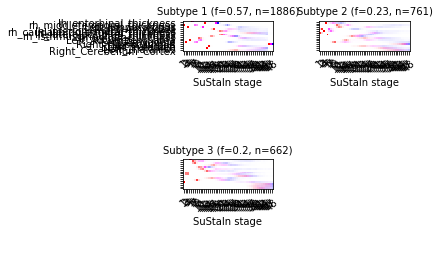

In [20]:
# # Output a figure showing the ground truth
# temp_gt_sequence = gt_sequence.reshape((gt_sequence.shape[0],gt_sequence.shape[1],1))
# temp_gt_f = np.asarray(gt_f).reshape(len(gt_f),1)
# pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,temp_gt_sequence,temp_gt_f,M)
# _ = plt.suptitle('Figure 3: Ground truth progression pattern')

# The code below opens the results for the ground truth number of subtypes
# and plots the output
plt.figure(figsize = (20,20))
M = 3309  #maybe wrong
s = 2 #maybe wrong
pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filepath             = Path(pickle_filename_s)
pickle_file                 = open(pickle_filename_s, 'rb')
loaded_variables            = pickle.load(pickle_file)
samples_sequence            = loaded_variables["samples_sequence"]
samples_f                   = loaded_variables["samples_f"]
pickle_file.close()

fig, ax = pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M)
# plt.title('Figure 4: SuStaIn output')
plt.show()



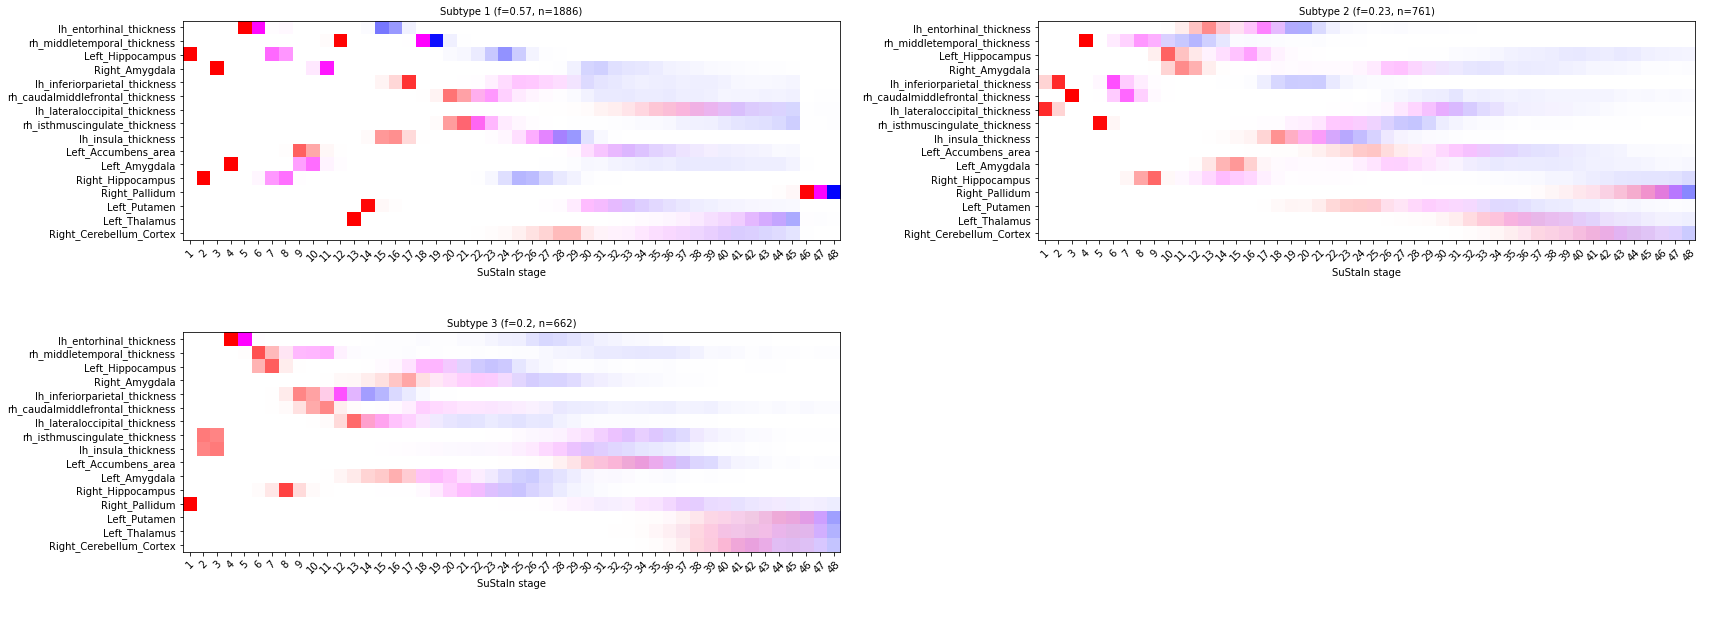

In [21]:
#Resize so this is a little more legible
fig.set_size_inches(40, 10, forward=True)
ax[0][1].set_yticklabels(ax[0][0].get_yticklabels())
ax[1][0].set_yticklabels(ax[0][0].get_yticklabels())
fig.subplots_adjust(wspace=.3, hspace=0)
fig

In [25]:
fig.set_size_inches(40, 10, forward=True)
ax[0][1].set_yticklabels(ax[0][0].get_yticklabels())
ax[1][0].set_yticklabels(ax[0][0].get_yticklabels())
fig.savefig('sustain_results.png')
fig.subplots_adjust(wspace=.3, hspace=0)

We can visualize the most likely subtypes model (3 subtypes, see cross-validation section below). Each time point (x axis) represents a likely negative z-score change event i.e. the hippocampus volume goes to z=-2. We initially selected 16 biomarkers and 3 z-score changes for each biomarker so there are 48 event stages. 

Red, pink, blue represents z scores of 1,2,3 respectively (3 being more atrophy)

In subtype 1 (57% of adni images, n=1886), There is clear initial atrophy in the hippocampus, then amygdala, then entorhinal cortex. We also see pallidum atrophy only towards the very end.

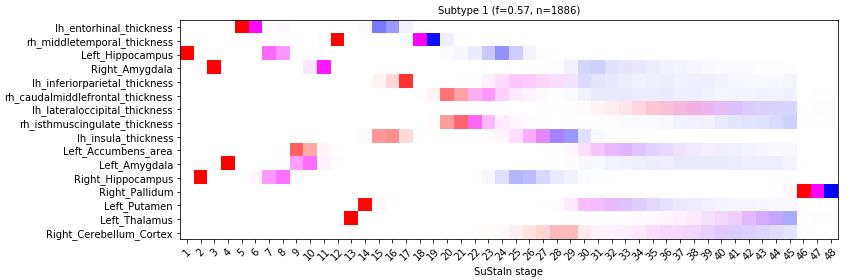

In [36]:
Image(filename='sustain1.png') 

Subtype 2 (23%, n=761) has shows earlier atrophy in cortical thickness measures

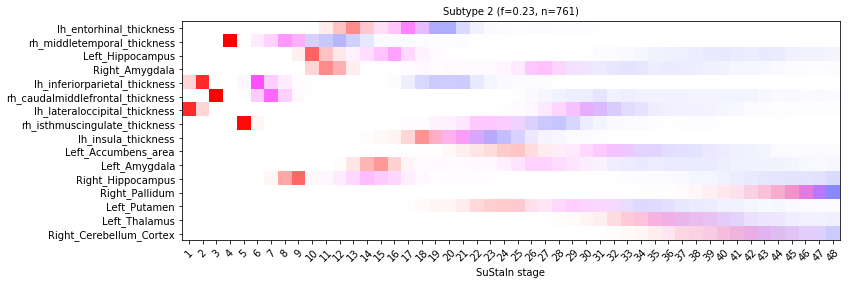

In [29]:
Image(filename='sustain2.png') 

Subtype 3 (20% n=662) shows less distinct patterns. Pallidum is the first z-score change. We also see early insula thickness and entorhinal thickness changes

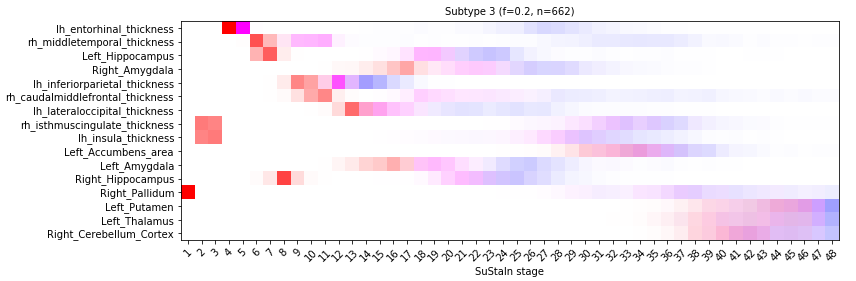

In [30]:
Image(filename='sustain3.png') 

# Cross Validation
Here we go through each subtypes model. Based on likelihoods and information added (CCIV), 3-subtypes looks to be the best model

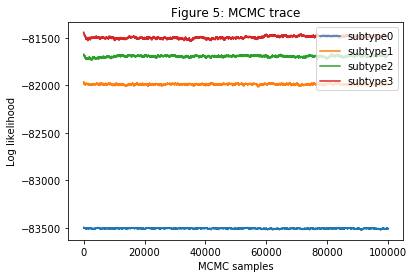

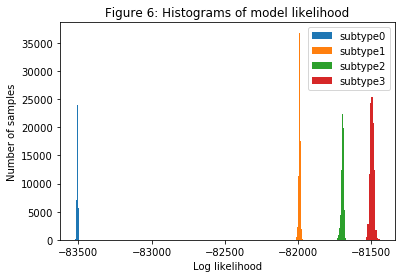

In [31]:
# go through each subtypes model and plot MCMC samples of the likelihood
for s in range(N_S_max):
    pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pickle_filepath             = Path(pickle_filename_s)
    pickle_file                 = open(pickle_filename_s, 'rb')
    loaded_variables            = pickle.load(pickle_file)
    samples_likelihood          = loaded_variables["samples_likelihood"]
    pickle_file.close()

    _ = plt.figure(0)
    _ = plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    _ = plt.figure(1)
    _ = plt.hist(samples_likelihood, label="subtype" + str(s))
    
_ = plt.figure(0)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('MCMC samples')
_ = plt.ylabel('Log likelihood')
_ = plt.title('Figure 5: MCMC trace')
    
_ = plt.figure(1)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Log likelihood')  
_ = plt.ylabel('Number of samples')  
_ = plt.title('Figure 6: Histograms of model likelihood')

In [32]:
index_control = df_z['Group'] == 'CN'
index_control
labels = 1 * np.ones(df_z.shape[0], dtype = np.int64)
labels[index_control] = 0
N_folds = 3
labels
cv = sklearn.model_selection.StratifiedKFold(n_splits=N_folds,shuffle=True)
cv_it = cv.split(df_z, labels)
test_idxs                = []
for train, test in cv_it:
    test_idxs.append(test)
test_idxs                = np.array(test_idxs)

/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/ocean/projects/asc170022p/mare398/envs/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `n

In [33]:
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold0_subtype0.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold0_subtype1.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold0_subtype2.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold0_subtype3.pickle


Folds:  33%|███▎      | 1/3 [01:10<02:20, 70.43s/it]

Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold1_subtype0.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold1_subtype1.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold1_subtype2.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold1_subtype3.pickle


Folds:  67%|██████▋   | 2/3 [02:22<01:11, 71.16s/it]

Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold2_subtype0.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold2_subtype1.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold2_subtype2.pickle
Loading /ocean/projects/asc170022p/mare398/SuStaIn/adni/pickle_files/adni_fold2_subtype3.pickle


Folds: 100%|██████████| 3/3 [03:33<00:00, 71.02s/it]


Average test set log-likelihood for each subtype model: [-27855.3833151  -27378.21791249 -27290.45920649 -27248.12847698]
CVIC for each subtype model: [166679.39753627 163482.38028035 162872.54632926 163161.18702459]


CVIC for each subtype model: [166679.39753627 163482.38028035 162872.54632926 163161.18702459]
Average test set log-likelihood for each subtype model: [-27855.3833151  -27378.21791249 -27290.45920649 -27248.12847698]


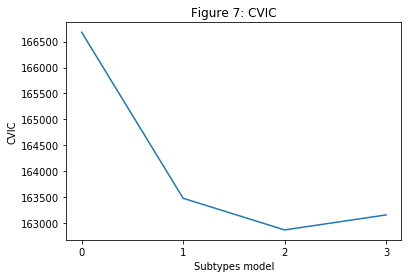

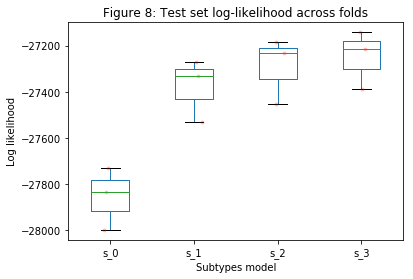

In [34]:
# go through each subtypes model and plot the log-likelihood on the test set and the CVIC
print("CVIC for each subtype model: " + str(CVIC))
print("Average test set log-likelihood for each subtype model: " + str(np.mean(loglike_matrix, 0)))

_ = plt.figure(1)    
_ = plt.plot(np.arange(N_S_max,dtype=int),CVIC)
_ = plt.xticks(np.arange(N_S_max,dtype=int))
_ = plt.ylabel('CVIC')  
_ = plt.xlabel('Subtypes model') 
_ = plt.title('Figure 7: CVIC')

_ = plt.figure(0)
df_loglike                                 = pd.DataFrame(data = loglike_matrix, columns = ["s_" + str(i) for i in range(sustain_input.N_S_max)])
df_loglike.boxplot(grid=False)
for i in range(sustain_input.N_S_max):
    y                                   = df_loglike[["s_" + str(i)]]
    x                                   = np.random.normal(1+i, 0.04, size=len(y)) # Add some random "jitter" to the x-axis
    pylab.plot(x, y, 'r.', alpha=0.2)
_ = plt.ylabel('Log likelihood')  
_ = plt.xlabel('Subtypes model') 
_ = plt.title('Figure 8: Test set log-likelihood across folds')